In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import  kstest
from scipy.integrate import quad
from tqdm import tqdm
from scipy.stats import johnsonsu


# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [2]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [3]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [4]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [5]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

23.783632811454414

## Метод условного математического ожидания (Beisser)

In [6]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [7]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

6.908159755754296

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

ответ 29.8

In [8]:
def JU(w, S, K, r, T, sigma, rho):

    N = len(w)  
    sigma_matrix = sigma**2 * T * np.ones_like(rho)  
    
    U1 = np.sum(w * S)

    exp_r_T = np.exp(r * T)
    wS_exp_r_T = w * S * exp_r_T

    U2_0_diag = np.sum(wS_exp_r_T**2)  
    U2_0_offdiag = np.sum(w[:, None] * S[:, None] * w[None, :] * S[None, :] *
                          np.exp(sigma_matrix * exp_r_T**2) * (1 - np.eye(N)))  
    U2_0 = U2_0_diag + U2_0_offdiag
    wS_product = w[:, None] * S[:, None] * w[None, :] * S[None, :]
    rho_sigma = sigma_matrix * rho

    U2_der_1 = np.sum(wS_product * rho_sigma)
    U2_der_2 = np.sum(wS_product * (rho_sigma**2))
    U2_der_3 = np.sum(wS_product * (rho_sigma**3))
    m_0 = 2 * np.log(U1) - 0.5 * np.log(U2_0)
    nu_0 = np.log(U2_0) - 2 * np.log(U1)
    a1 = -U2_der_1 / (2 * U2_0)
    a2 = 2 * a1**2 - U2_der_2 / (2 * U2_0)
    a3 = 6 * a1 * a2 - 4 * a1**3 - U2_der_3 / (2 * U2_0)

    z1 = a2 - a3
    z2 = a3
    z3 = 0 
    sqrt_nu_0 = np.sqrt(nu_0)
    y1 = (m_0 - np.log(K)) / sqrt_nu_0 + sqrt_nu_0
    y2 = y1 - sqrt_nu_0

    p_y = lambda x: (1 / np.sqrt(2 * np.pi * nu_0)) * np.exp(-(x - m_0)**2 / (2 * nu_0))
    dp_y = lambda x: -p_y(x) * (x - m_0) / nu_0
    d2p_y = lambda x: p_y(x) * ((x - m_0) / nu_0)**2 - p_y(x) / nu_0
    BC = (U1 * norm.cdf(y1) - K * norm.cdf(y2) +
          K * (z1 * p_y(np.log(K)) + z2 * dp_y(np.log(K)) + z3 * d2p_y(np.log(K))))

    return BC



BC = JU(w, S, K, r, T, sigma, rho)
BC


30.025244786503237

## Метод моментов (Log-normal moment matching, Levy’s matching)

In [9]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [10]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

28.051966214249894

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [11]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [12]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

24.495775089623557

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [13]:

# ответ = 27.98

In [14]:
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):

    N = len(S)
    mu = (r - 0.5 * sigma**2) * T
    cov_matrix = np.outer(sigma, sigma) * rho * T

    num_samples = 1000000
    np.random.seed(0)
    log_S = np.random.multivariate_normal(mu, cov_matrix, num_samples)
    S_T = S * np.exp(log_S)
    B_T = np.dot(S_T, w)

    mean_BT = np.mean(B_T)
    std_BT = np.std(B_T)
    skew_BT = np.mean((B_T - mean_BT)**3) / std_BT**3
    kurt_BT = np.mean((B_T - mean_BT)**4) / std_BT**4

    params = johnsonsu.fit(B_T)
    a, b, loc, scale = params

    def integrand(x):
        return (x - K) * johnsonsu.pdf(x, a, b, loc=loc, scale=scale)

    expected_payoff, _ = quad(integrand, K, np.inf)

    basket_call = np.exp(-r * T) * expected_payoff

    print(f"Basket Call Option Price (4M Approximation): {basket_call:.2f}")


    return basket_call

basket_call_price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


Basket Call Option Price (4M Approximation): 27.94


In [15]:
basket_call_price

27.937729380770993

## Метод Монте-Карло

In [16]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [17]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

28.008538369069836

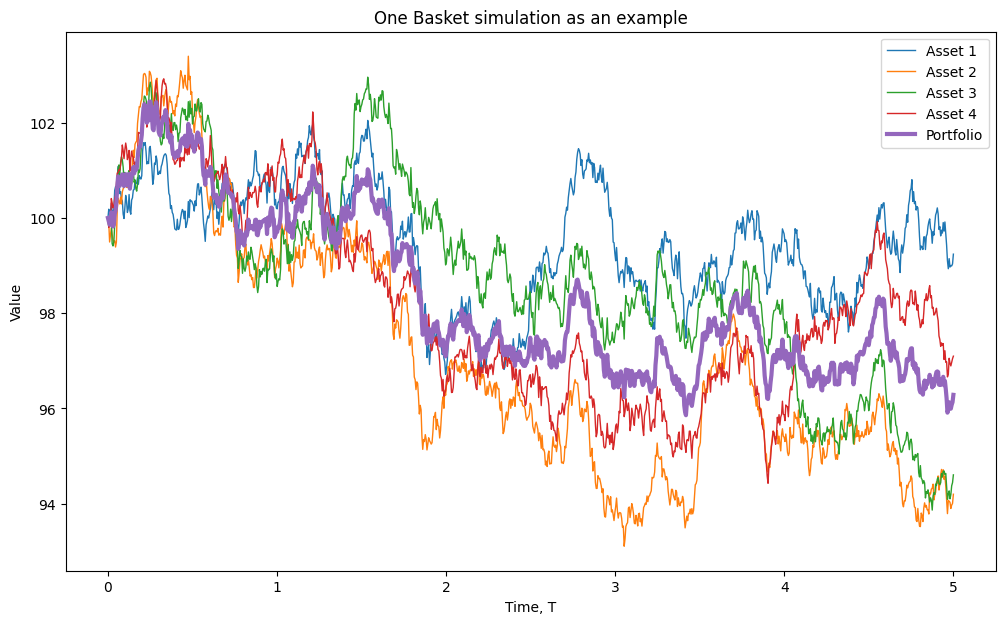

In [18]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [19]:
def monte_carlo_pricing(F, K, T, r, sigma, rho, w, n_sims=10**4, n_steps=5000):

    n_assets = len(F)
    dt = T / n_steps  # Time step size
    cov_matrix = np.outer(sigma, sigma) * rho  # Covariance matrix for Brownian motion

    # Initialize asset prices
    S = np.zeros((n_sims, n_assets))
    S[...] = F  # Broadcast initial prices across simulations

    # Simulate asset price paths
    for _ in tqdm(range(n_steps), desc="Simulating paths"):
        dW = np.random.multivariate_normal(np.zeros(n_assets), cov_matrix, size=n_sims) * np.sqrt(dt)
        drift = r * S * dt
        diffusion = S * dW
        S += drift + diffusion

    # Calculate portfolio values at maturity
    portfolio_values = S @ w

    # Calculate option payoffs
    call_payoffs = np.maximum(portfolio_values - K, 0)
    put_payoffs = np.maximum(K - portfolio_values, 0)

    # Discounted mean payoff
    discount_factor = np.exp(-r * T)
    call_price = discount_factor * np.mean(call_payoffs)
    put_price = discount_factor * np.mean(put_payoffs)

    return call_price, put_price

Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [ ]:


def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)  


    COV = np.outer(sigma, sigma) * rho
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)

    
    B_T = np.zeros(N_mc)

    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - 0.5 * sigma[k] ** 2) * T + W[:, k]) * w[k]

    payoff = np.maximum(B_T - K, 0)


    mean = np.mean(payoff) * np.exp(-r * T)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std  


def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975) * price_std / np.sqrt(N_mc)  
    hi = price + norm.ppf(0.975) * price_std / np.sqrt(N_mc)  
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")


In [21]:
call_price_mc, put_price_mc = monte_carlo_pricing(F, K, T, r, sigma, rho, w)

Simulating paths: 100%|██████████| 5000/5000 [00:06<00:00, 826.01it/s]


In [22]:
print(f"Call price by Monte Carlo: {call_price_mc:.4f}")
print(f"Put price by Monte Carlo: {put_price_mc:.4f}")

Call price by Monte Carlo: 27.4452
Put price by Monte Carlo: 27.9976


In [23]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 27.997914197934225, ci: 27.86790372631094 < price < 28.127924669557512 with 95% prob


### Задача

In [ ]:
# Постройте гистограммы распределения МС оценок для опионов кол и пут,
# на графики нанесите границы доверительного интервала, среднее значение (вертикальные линии),
# выдвините гипотезу о законе распределения оценок и проверьте ее статистически.

# ваш код

In [26]:
def analyze_MC_distribution_v2(S, K, T, w, r, q, rho, sigma, N_mc, M):
    call_prices = []
    put_prices = []
    
    for _ in tqdm(range(M), desc="Симуляции Монте-Карло"):
        call, put = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
        call_prices.append(np.mean(call))
        put_prices.append(np.mean(put))
    
    call_prices = np.array(call_prices)
    put_prices = np.array(put_prices)
    
    call_mean = np.mean(call_prices)
    call_std = np.std(call_prices)
    put_mean = np.mean(put_prices)
    put_std = np.std(put_prices)
    
    z = norm.ppf(0.975)
    call_ci_low = call_mean - z * call_std / np.sqrt(M)
    call_ci_high = call_mean + z * call_std / np.sqrt(M)
    put_ci_low = put_mean - z * put_std / np.sqrt(M)
    put_ci_high = put_mean + z * put_std / np.sqrt(M)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(call_prices, bins=25, alpha=0.8, color='teal', edgecolor='darkblue')
    plt.axvline(call_mean, color='darkred', linestyle='solid', linewidth=2, label=f'Среднее: {call_mean:.2f}')
    plt.axvline(call_ci_low, color='purple', linestyle='dashdot', linewidth=2, label='95% ДИ')
    plt.axvline(call_ci_high, color='purple', linestyle='dashdot', linewidth=2)
    plt.title('Распределение цен опциона Call')
    plt.xlabel('Цена Call')
    plt.ylabel('Частота')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(put_prices, bins=25, alpha=0.8, color='crimson', edgecolor='darkred')
    plt.axvline(put_mean, color='navy', linestyle='solid', linewidth=2, label=f'Среднее: {put_mean:.2f}')
    plt.axvline(put_ci_low, color='orange', linestyle='dashed', linewidth=2, label='95% ДИ')
    plt.axvline(put_ci_high, color='orange', linestyle='dashed', linewidth=2)
    plt.title('Распределение цен опциона Put')
    plt.xlabel('Цена Put')
    plt.ylabel('Частота')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    stat_call, p_call = shapiro(call_prices)
    stat_put, p_put = shapiro(put_prices)
        
    return {
        'call_prices': call_prices,
        'put_prices': put_prices,
        'call_mean': call_mean,
        'call_std': call_std,
        'call_ci_low': call_ci_low,
        'call_ci_high': call_ci_high,
        'put_mean': put_mean,
        'put_std': put_std,
        'put_ci_low': put_ci_low,
        'put_ci_high': put_ci_high
    }


---

## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [ ]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# предложите свою визуализацию для корзин с разными весами активов
# ваш код допишите в ячейке ниже

mean call basket price = 27.8478, ci: 27.4434 < price < 28.2521 с 95% вероятностью


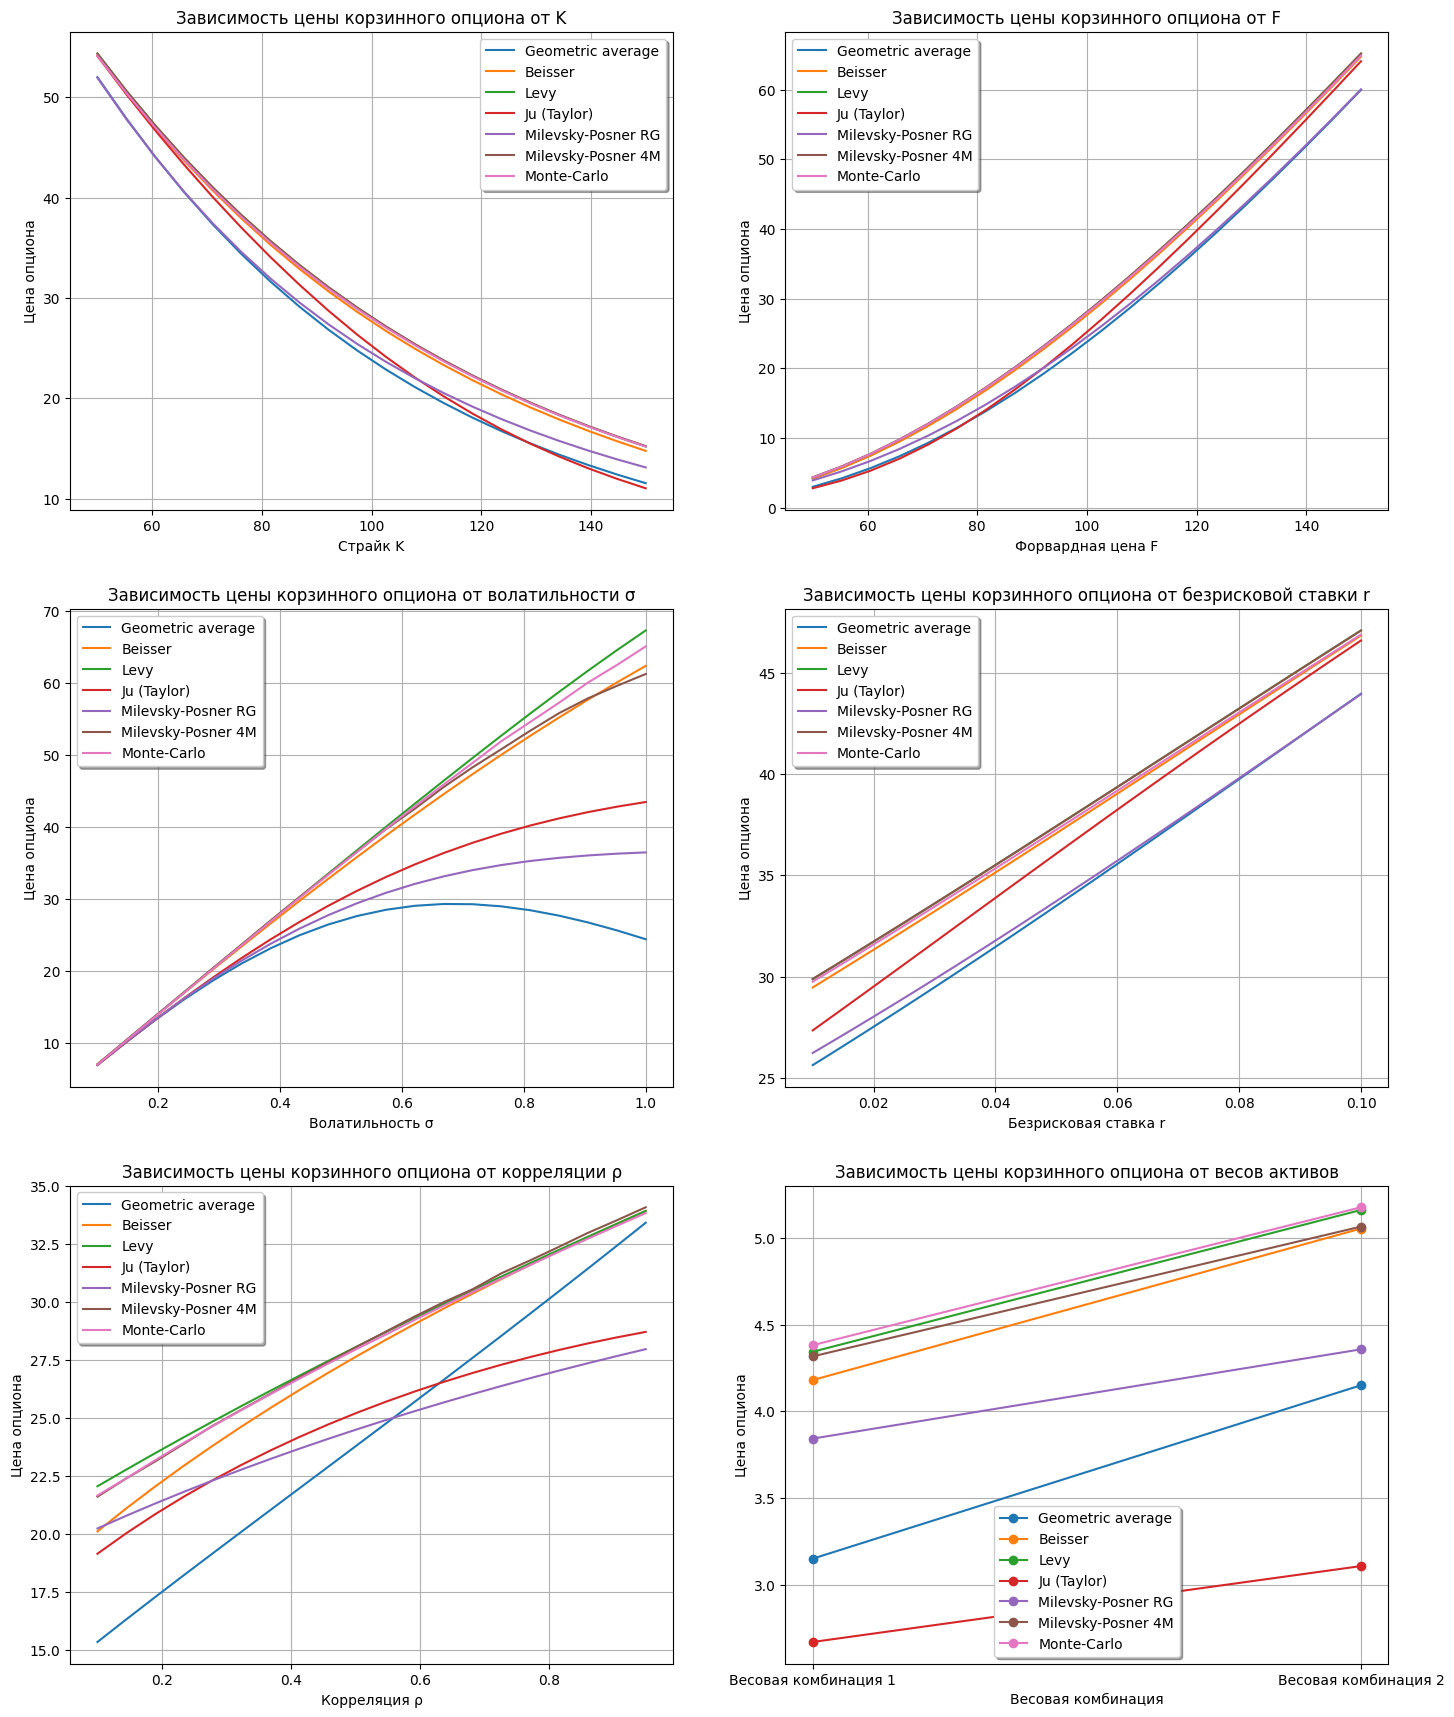

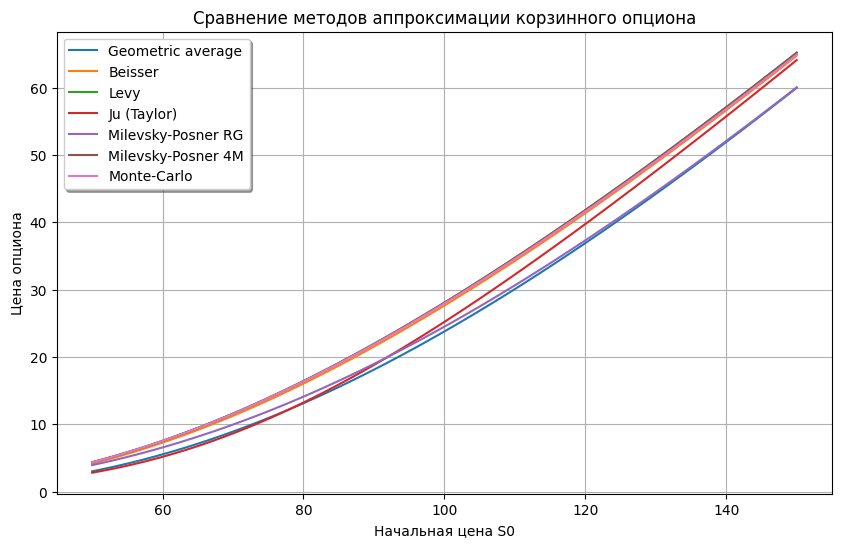

In [ ]:


N_mc = 100000 

def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)
    
    m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
    v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)
    
    K_star = K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)
    
    d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
    d2 = d1 - v_tilde
    
    basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))
    
    return basket_call


def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 0.5 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma, rho):
    a = S * w * sigma
    sigmaz = np.sqrt(a.T @ rho @ a)
    sqrt_T = np.sqrt(T)
    

    result = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho))
    z_star = result.x[0]
    
    basket_call = 0
    for i in range(len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
        K_star = S[i] * np.exp(sigma[i] * m * z_star - 0.5 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        S_star = S[i] * np.exp((r - q[i] - 0.5 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
        d1 = (np.log(S[i] / K_star) + (r - q[i] + 0.5 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
        d2 = d1 - sigma_star * np.sqrt(T)
        basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call


def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    M = np.dot(w, F)
    V2 = 0
    for i in range(len(w)):
        for j in range(len(w)):
            V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
    m = 2 * np.log(M) - 0.5 * np.log(V2)
    v = np.sqrt(np.log(V2) - 2 * np.log(M))
    d1 = (m - np.log(K) + v**2) / v
    d2 = d1 - v
    basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
    return basket_call

def ju_taylor_approximation_call(S, K, T, sigma, w, rho, r=0, delta=None):
    N = len(S)
    if delta is None:
        delta = np.zeros(N)
    
    mu_B = np.sum(w * S * np.exp((r - delta) * T))
    cov_returns = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            cov_returns[i, j] = rho[i, j] * sigma[i] * sigma[j] * T
    var_B = np.dot(w, np.dot(cov_returns, w))
    std_B = np.sqrt(var_B)
  
    skew_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                skew_B += w[i] * w[j] * w[k] * sigma[i] * sigma[j] * sigma[k] * T ** 1.5 * \
                          (rho[i, j] * rho[i, k] * rho[j, k])
    skew_B /= std_B ** 3
    
    kurt_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    kurt_B += w[i] * w[j] * w[k] * w[l] * sigma[i] * sigma[j] * sigma[k] * sigma[l] * T ** 2 * \
                              (rho[i, j] * rho[i, k] * rho[i, l] * rho[j, k] * rho[j, l] * rho[k, l])
    kurt_B = kurt_B / std_B ** 4 - 3
    

    d = (np.log(mu_B / K)) / std_B
    d_adj = d + (skew_B / 6) * (d ** 2 - 1) + (kurt_B / 24) * (d ** 3 - 3 * d) - \
            (skew_B ** 2 / 36) * (2 * d ** 3 - 5 * d)
    d2_adj = d_adj - std_B
    Nd_adj = norm.cdf(d_adj)
    Nd2_adj = norm.cdf(d2_adj)

    basket_call = np.exp(-r * T) * (mu_B * Nd_adj - K * Nd2_adj)

    return basket_call


def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    M = np.dot(w, F)
    V2 = 0
    for i in range(len(w)):
        for j in range(len(w)):
            V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
    alpha = (2 * V2 - M**2) / (V2 - M**2)
    beta = (V2 - M**2) / (V2 * M)
   
    g1 = gamma.cdf(1/K, a=alpha - 1, scale=beta)
    g2 = gamma.cdf(1/K, a=alpha, scale=beta)
    basket_call = np.exp(-r * T) * (M * g1 - K * g2)
    return basket_call


def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Рассчитывает цену корзинного опциона колл методом моментов высших порядков (4M).
    """

    num_samples = 100000
    np.random.seed(0)
    log_S = np.random.multivariate_normal(
        (r - 0.5 * sigma**2) * T, 
        np.outer(sigma, sigma) * rho * T, 
        num_samples
    )
    S_T = S * np.exp(log_S)
    B_T = np.dot(S_T, w)
    
    mean_BT = np.mean(B_T)
    std_BT = np.std(B_T)
    skew_BT = np.mean((B_T - mean_BT)**3) / std_BT**3
    kurt_BT = np.mean((B_T - mean_BT)**4) / std_BT**4
    
   
    params = johnsonsu.fit(B_T)
    a, b, loc, scale = params
    
    def integrand(x):
        return (x - K) * johnsonsu.pdf(x, a, b, loc=loc, scale=scale)
    
    expected_payoff, _ = quad(integrand, K, np.inf)
    
    basket_call = np.exp(-r * T) * expected_payoff
    
    return basket_call


def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho * T
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc)
    S_T = S * np.exp((r - q - 0.5 * sigma**2) * T + W)
    B_T = np.dot(S_T, w)
    payoff = np.maximum(B_T - K, 0)
    basket_call = np.exp(-r * T) * np.mean(payoff)
    return basket_call


def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho * T
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc)
    S_T = S * np.exp((r - q - 0.5 * sigma**2) * T + W)
    B_T = np.dot(S_T, w)
    payoff = np.maximum(B_T - K, 0)
    mean = np.exp(-r * T) * np.mean(payoff)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975) * price_std / np.sqrt(N_mc)   
    hi = price + norm.ppf(0.975) * price_std / np.sqrt(N_mc)   
    print(f"mean call basket price = {price:.4f}, ci: {lo:.4f} < price < {hi:.4f} с 95% вероятностью")

call_price_mc, std_mc = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(call_price_mc, std_mc, N_mc)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.tight_layout(pad=5.0)


def calculate_prices(S, K, T, w, r, q, rho, sigma, N_mc):
    geom_avg = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser_price = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma, rho)
    Levy_price = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju_price = JU(S, K, T, sigma, w, rho, r)
    MP_RG_price = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP_4M_price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC_price = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    return geom_avg, Beisser_price, Levy_price, Ju_price, MP_RG_price, MP_4M_price, MC_price

iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K_data[i], T, w, r, q, rho, sigma, N_mc)

axs[0][0].plot(K_data, geom_avg, label='Geometric average')
axs[0][0].plot(K_data, Beisser, label='Beisser')
axs[0][0].plot(K_data, Levy, label='Levy')
axs[0][0].plot(K_data, Ju_prices, label='Ju (Taylor)')
axs[0][0].plot(K_data, MP_RG, label='Milevsky-Posner RG')
axs[0][0].plot(K_data, MP_4M, label='Milevsky-Posner 4M')
axs[0][0].plot(K_data, MC, label='Monte-Carlo')
axs[0][0].set_title('Зависимость цены корзинного опциона от K')
axs[0][0].set_xlabel('Страйк K')
axs[0][0].set_ylabel('Цена опциона')
axs[0][0].legend(loc='best', fancybox=True, shadow=True)
axs[0][0].grid(True)


iters = 20
F_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    S_new = F_data[i] * np.ones(N) * np.exp(-r * T)
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_new, K, T, w, r, q, rho, sigma, N_mc)

axs[0][1].plot(F_data, geom_avg, label='Geometric average')
axs[0][1].plot(F_data, Beisser, label='Beisser')
axs[0][1].plot(F_data, Levy, label='Levy')
axs[0][1].plot(F_data, Ju_prices, label='Ju (Taylor)')
axs[0][1].plot(F_data, MP_RG, label='Milevsky-Posner RG')
axs[0][1].plot(F_data, MP_4M, label='Milevsky-Posner 4M')
axs[0][1].plot(F_data, MC, label='Monte-Carlo')
axs[0][1].set_title('Зависимость цены корзинного опциона от F')
axs[0][1].set_xlabel('Форвардная цена F')
axs[0][1].set_ylabel('Цена опциона')
axs[0][1].legend(loc='best', fancybox=True, shadow=True)
axs[0][1].grid(True)

iters = 20
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    sigma_new = np.ones(N) * sigma_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r, q, rho, sigma_new, N_mc)

axs[1][0].plot(sigma_data, geom_avg, label='Geometric average')
axs[1][0].plot(sigma_data, Beisser, label='Beisser')
axs[1][0].plot(sigma_data, Levy, label='Levy')
axs[1][0].plot(sigma_data, Ju_prices, label='Ju (Taylor)')
axs[1][0].plot(sigma_data, MP_RG, label='Milevsky-Posner RG')
axs[1][0].plot(sigma_data, MP_4M, label='Milevsky-Posner 4M')
axs[1][0].plot(sigma_data, MC, label='Monte-Carlo')
axs[1][0].set_title('Зависимость цены корзинного опциона от волатильности σ')
axs[1][0].set_xlabel('Волатильность σ')
axs[1][0].set_ylabel('Цена опциона')
axs[1][0].legend(loc='best', fancybox=True, shadow=True)
axs[1][0].grid(True)

iters = 20
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    r_new = r_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r_new, q, rho, sigma, N_mc)

axs[1][1].plot(r_data, geom_avg, label='Geometric average')
axs[1][1].plot(r_data, Beisser, label='Beisser')
axs[1][1].plot(r_data, Levy, label='Levy')
axs[1][1].plot(r_data, Ju_prices, label='Ju (Taylor)')
axs[1][1].plot(r_data, MP_RG, label='Milevsky-Posner RG')
axs[1][1].plot(r_data, MP_4M, label='Milevsky-Posner 4M')
axs[1][1].plot(r_data, MC, label='Monte-Carlo')
axs[1][1].set_title('Зависимость цены корзинного опциона от безрисковой ставки r')
axs[1][1].set_xlabel('Безрисковая ставка r')
axs[1][1].set_ylabel('Цена опциона')
axs[1][1].legend(loc='best', fancybox=True, shadow=True)
axs[1][1].grid(True)

iters = 20
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    rho_new = np.ones((N, N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r, q, rho_new, sigma, N_mc)

axs[2][0].plot(rho_data, geom_avg, label='Geometric average')
axs[2][0].plot(rho_data, Beisser, label='Beisser')
axs[2][0].plot(rho_data, Levy, label='Levy')
axs[2][0].plot(rho_data, Ju_prices, label='Ju (Taylor)')
axs[2][0].plot(rho_data, MP_RG, label='Milevsky-Posner RG')
axs[2][0].plot(rho_data, MP_4M, label='Milevsky-Posner 4M')
axs[2][0].plot(rho_data, MC, label='Monte-Carlo')
axs[2][0].set_title('Зависимость цены корзинного опциона от корреляции ρ')
axs[2][0].set_xlabel('Корреляция ρ')
axs[2][0].set_ylabel('Цена опциона')
axs[2][0].legend(loc='best', fancybox=True, shadow=True)
axs[2][0].grid(True)

iters = 2
w_data = np.array([[0.5, 0.2, 0.2, 0.1], [0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30], [50, 40, 60, 30]]) 
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    S_current = S_data[i]
    w_current = w_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_current, K, T, w_current, r, q, rho, sigma, N_mc)

labels = ['Весовая комбинация 1', 'Весовая комбинация 2']

axs[2][1].plot(labels, geom_avg, marker='o', label='Geometric average')
axs[2][1].plot(labels, Beisser, marker='o', label='Beisser')
axs[2][1].plot(labels, Levy, marker='o', label='Levy')
axs[2][1].plot(labels, Ju_prices, marker='o', label='Ju (Taylor)')
axs[2][1].plot(labels, MP_RG, marker='o', label='Milevsky-Posner RG')
axs[2][1].plot(labels, MP_4M, marker='o', label='Milevsky-Posner 4M')
axs[2][1].plot(labels, MC, marker='o', label='Monte-Carlo')
axs[2][1].set_title('Зависимость цены корзинного опциона от весов активов')
axs[2][1].set_xlabel('Весовая комбинация')
axs[2][1].set_ylabel('Цена опциона')
axs[2][1].legend(loc='best', fancybox=True, shadow=True)
axs[2][1].grid(True)

plt.show()

def pdfs_comparison():
    iters = 100
    S_data = np.linspace(50, 150, iters)
    geom_avg = np.zeros(iters)
    Beisser = np.zeros(iters)
    Levy = np.zeros(iters)
    Ju_prices = np.zeros(iters)
    MP_RG = np.zeros(iters)
    MP_4M = np.zeros(iters)
    MC = np.zeros(iters)

    for i in range(iters):
        S_current = S_data[i] * np.ones(N)
        geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_current, K, T, w, r, q, rho, sigma, N_mc)

    plt.figure(figsize=(10, 6))
    plt.plot(S_data, geom_avg, label='Geometric average')
    plt.plot(S_data, Beisser, label='Beisser')
    plt.plot(S_data, Levy, label='Levy')
    plt.plot(S_data, Ju_prices, label='Ju (Taylor)')
    plt.plot(S_data, MP_RG, label='Milevsky-Posner RG')
    plt.plot(S_data, MP_4M, label='Milevsky-Posner 4M')
    plt.plot(S_data, MC, label='Monte-Carlo')
    plt.title('Сравнение методов аппроксимации корзинного опциона')
    plt.xlabel('Начальная цена S0')
    plt.ylabel('Цена опциона')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()


pdfs_comparison() 


# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [2]:
pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras_tuner as kt


* Generate_data

In [3]:
def generate_basket_prices_gbm(num_samples, num_assets, T, r, K, rho, S0_range, sigma_range):
    np.random.seed(42)

    S0 = np.random.uniform(S0_range[0], S0_range[1], size=(num_samples, num_assets))
    sigma = np.random.uniform(sigma_range[0], sigma_range[1], size=(num_samples, num_assets))
    weights = np.random.uniform(0.2, 0.8, size=(num_samples, num_assets))
    weights /= weights.sum(axis=1, keepdims=True)


    cov_matrix = rho * np.ones((num_assets, num_assets)) + (1 - rho) * np.eye(num_assets)
    L = np.linalg.cholesky(cov_matrix)


    Z = np.random.randn(num_samples, num_assets) @ L.T
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    
    basket_prices = np.sum(weights * ST, axis=1)
    payoffs = np.maximum(basket_prices - K, 0)

    
    data = pd.DataFrame({
        'basket_price': basket_prices,
        'payoff': payoffs
    })
    for i in range(num_assets):
        data[f'S0_{i}'] = S0[:, i]
        data[f'sigma_{i}'] = sigma[:, i]
        data[f'w_{i}'] = weights[:, i]

    return data


In [5]:
num_samples = 10000
num_assets = 5
T = 1.0
r = 0.05
K = 80
rho = 0.5
S0_range = (70, 150)
sigma_range = (0.2, 0.5)

data = generate_basket_prices_gbm(num_samples, num_assets, T, r, K, rho, S0_range, sigma_range)

X = data.drop(['basket_price', 'payoff'], axis=1).values
y = data['payoff'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



* Scaling

In [ ]:

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')  
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50


100/100 [==============================] - 2s 6ms/step - loss: 2361.2056 - mae: 36.4297 - val_loss: 2358.0574 - val_mae: 36.2196
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 2181.6392 - mae: 35.2230 - val_loss: 2126.2646 - val_mae: 34.0227
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 1935.4747 - mae: 32.5832 - val_loss: 1877.6294 - val_mae: 31.2849
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 1632.9689 - mae: 28.9597 - val_loss: 1530.9561 - val_mae: 27.8813
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 1338.6042 - mae: 25.8935 - val_loss: 1249.9821 - val_mae: 25.3539
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 1138.1722 - mae: 24.2892 - val_loss: 1117.3225 - val_mae: 24.4780
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 1045.1178 - mae: 23.6846 - val_loss: 1072.4790 - val_mae: 24.4972
Epoch 8/50
100/100

* Create model

* Comparison

In [12]:

y_pred = model.predict(X_test).flatten()

mc_price = np.exp(-r * T) * np.mean(y_test)
nn_price = np.exp(-r * T) * np.mean(y_pred)

print(f'Цена опциона методом Монте-Карло: {mc_price:.4f}')
print(f'Цена опциона нейронной сетью: {nn_price:.4f}')


63/63 [==============================] - 0s 2ms/step
Цена опциона методом Монте-Карло: 34.4829
Цена опциона нейронной сетью: 34.0678


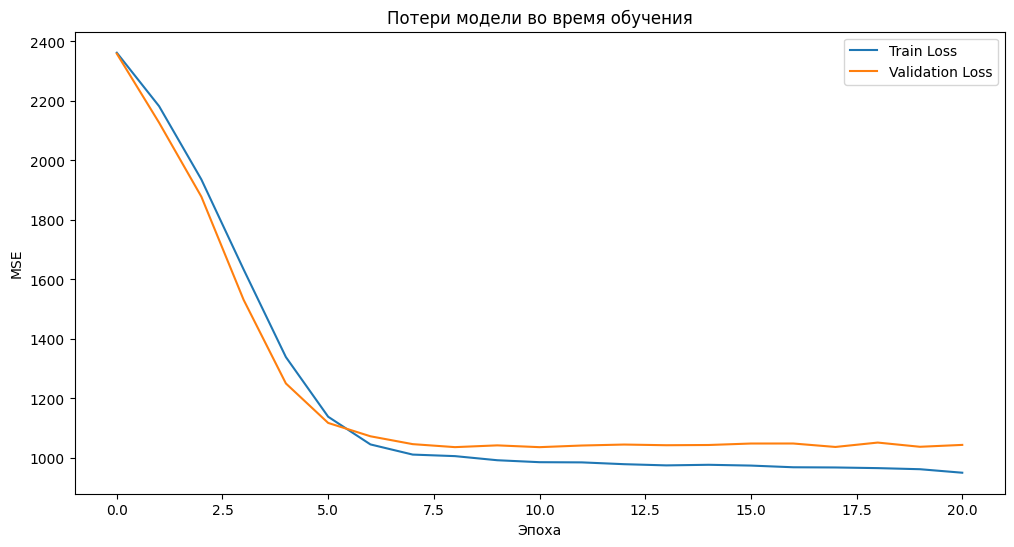

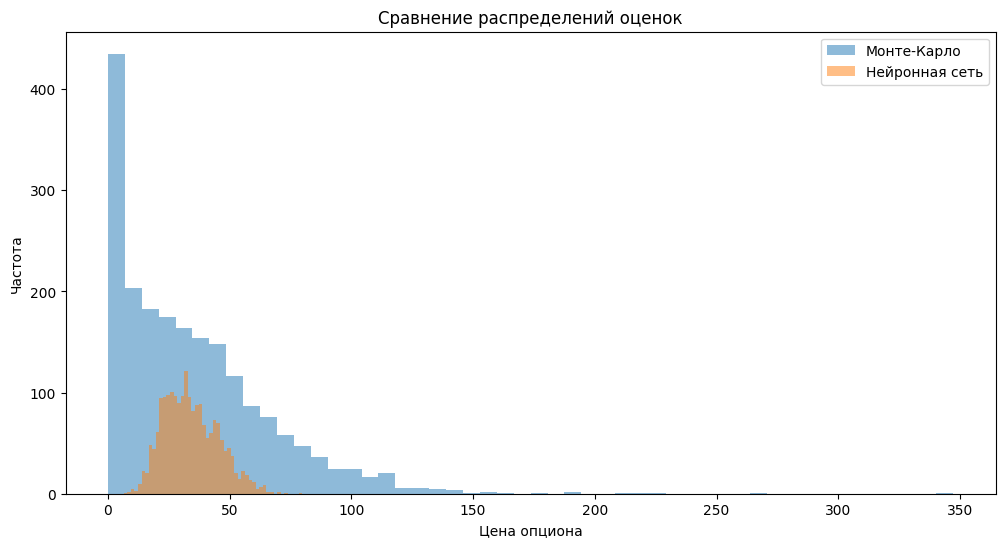

In [16]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.title('Потери модели во время обучения')
plt.show()


plt.figure(figsize=(12, 6))
plt.hist(y_test * np.exp(-r * T), bins=50, alpha=0.5, label='Монте-Карло')
plt.hist(y_pred * np.exp(-r * T), bins=50, alpha=0.5, label='Нейронная сеть')
plt.xlabel('Цена опциона')
plt.ylabel('Частота')
plt.legend()
plt.title('Сравнение распределений оценок')
plt.show()


* Выводы
- Выброс на гистограмме при цене 0 вызван тем, что в методе Монте-Карло есть значительное количество сценариев, где Basket Price<𝐾
 Такие сценарии формируют "нулевые" выплаты, что приводит к накоплению значений в точке 0
- Нейронная сеть показывает меньше выбросов благодаря сглаживанию предсказаний. Нейронная сеть не стремится строго предсказывать нули, а скорее выдает приближенные значения, что снижает частоту 0 на гистограмме.

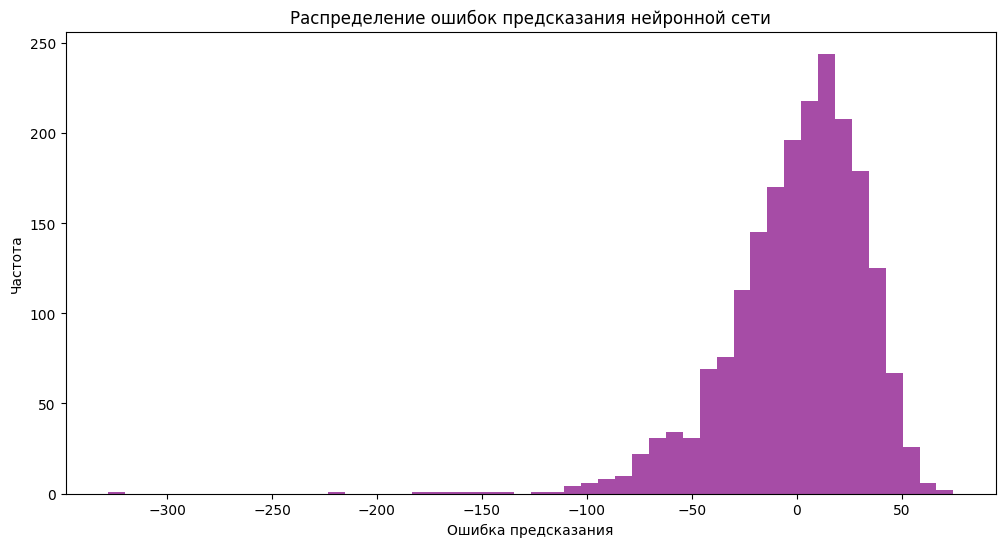

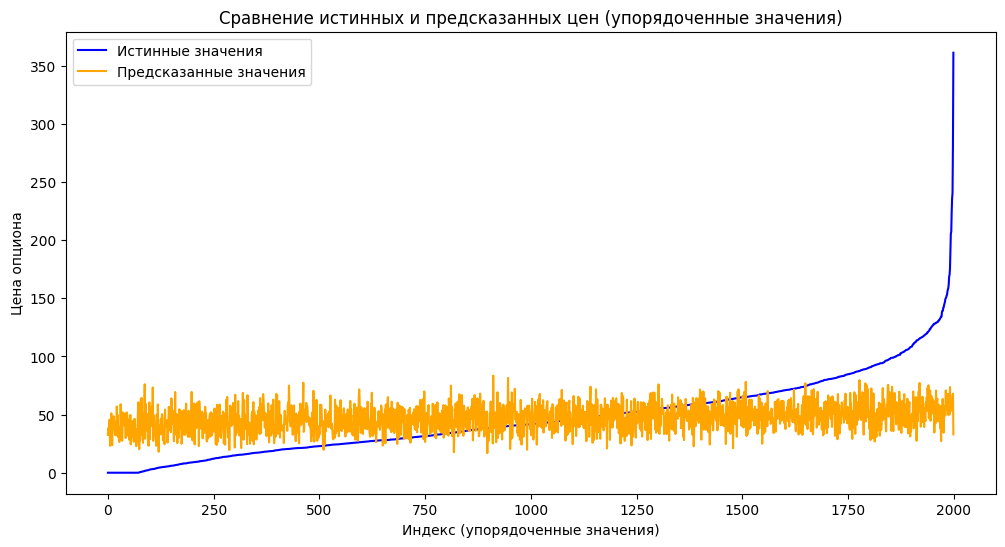

In [95]:

errors = (y_pred * np.exp(-r * T)) - (y_test * np.exp(-r * T))
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, alpha=0.7, color='purple')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок предсказания нейронной сети')
plt.show()


plt.figure(figsize=(12, 6))
sorted_indices = np.argsort(y_test * np.exp(-r * T))
sorted_y_test = (y_test * np.exp(-r * T))[sorted_indices]
sorted_y_pred = (y_pred * np.exp(-r * T))[sorted_indices]
plt.plot(sorted_y_test, label='Истинные значения', color='blue')
plt.plot(sorted_y_pred, label='Предсказанные значения', color='orange')
plt.xlabel('Индекс (упорядоченные значения)')
plt.ylabel('Цена опциона')
plt.title('Сравнение истинных и предсказанных цен (упорядоченные значения)')
plt.legend()
plt.show()
